<center><h1>BIG TRANSFER (BiT) MODEL</h1></center>
Because there is a presentation associated with this code, I will not be extensively annotating it. If you have any questions, please do not hesitate to contact me. 

In [ ]:

#########################################
######   INSTALLATIONS FOR COLAB   ######
#########################################

!pip install torch_lr_finder
!pip install timm

###########################
######   LIBRARIES   ######
###########################

# ------ STANDARD ------ #
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import copy
import statistics 
from tqdm.notebook import tqdm  
import random
%matplotlib inline

# ------ GOOGLE COLAB ------ #
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ------ TORCH MODULES ------ #
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Compose, Normalize, Resize
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from torch_lr_finder import LRFinder

# ------ TIMM ------ #
import timm

# ------ SKLEARN MODULES ------ #
import scipy.io
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

# ------  IMAGE DISPLAY ------ #
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

# ----- CUDA ------ #
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Mounted at /content/drive


<h2>READING IN THE DATA AND CREATING THE DATA LOADERS</h2>
All rather straight forward here.

In [ ]:
# ----- PATH -----
root_dir = "/content/drive/My Drive/"
training_directory = root_dir + 'ML_FinalProject/data/train'
validation_directory = root_dir + 'ML_FinalProject/data/validation'
test_directory = root_dir + 'ML_FinalProject/data/test'

# ----- TRANSFORMS / STANDARDIZATION -----

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
    
standard_transform = Compose([
                        Resize((224, 224)),
                        ToTensor(), 
                        Normalize(mean = imagenet_mean, 
                                  std = imagenet_std)
                    ])

test_transform = Compose([
                        Resize((224, 224)),
                        ToTensor()
                    ])

# ----- BUILD IMAGE FOLDERS -----

training_data = ImageFolder(training_directory, 
                            transform = standard_transform)

validation_data = ImageFolder(validation_directory, 
                              transform = standard_transform)

test_data = ImageFolder(test_directory, 
                              transform = test_transform)

# ----- DATA LOADERS -----

# Batch size 
batch_size = 32

train_loader = DataLoader(training_data, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=2, 
                          pin_memory=True)

val_loader = DataLoader(validation_data, 
                        batch_size, 
                        num_workers=2, 
                        pin_memory=True)

test_loader = DataLoader(test_data, 
                        1, 
                        num_workers=2, 
                        pin_memory=True)

# ----- NAMING THEM FOR MODEL TRAINING -----

image_datasets = {}
image_datasets['train'] = training_data
image_datasets['val'] = validation_data

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


<H2>LOADING THE PRE-TRAINED BiT MODEL</h2>
Using the Pytorch implementation through the Timm library. 

In [ ]:
# ------ DEFINING THE MODEL ----- # 

'''
Big Transfer (BiT) Model
    paper: https://arxiv.org/abs/1912.11370
    
    notes: 
      Parameters are frozen. Tests after unfreezing the parameters led to 
      unfavorable results, even after trials using dynamic learning rates.
'''

BiT = timm.create_model('resnetv2_101x1_bitm', pretrained=True)

for param in BiT.parameters():
  param.requires_grad = False

BiT.head.fc = nn.Conv2d(2048, 15, kernel_size=(1, 1), stride=(1, 1))

BiT = BiT.to(device)
BiT.eval()


ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm3)

<h2> SELECTING THE HYPERPARAMETERS</h2>

In [ ]:

# ------ PARARMETERS ------ #
epochs = 25
gamma = 0.1
step_size = 5

# ----- LOSS FUNCTION AND OPTIMIZER ------ # 

'''

Cross entropy loss was selected because it was the most frequently used in transfer
learning in the papers I read. SGD was used as the optimization function because
BiT is built off of a ResNet model; ResNet was created using SGD and as such, it 
is standard to use it during fine-tuning. However, to confirm that Adam did not work better
in this case I did also try using Adam as the optimization function. The validation error
rate was slightly worse than with SGD; as such, there was no reason to not use SGD. 

'''

criterion = nn.CrossEntropyLoss()

# Setting the null optimizer before using the learning rate finder
optimizer = optim.SGD(BiT.parameters(), lr = 1e-7)

'''
What was the best learning rate? 
5.2e-2
'''

#lr_finder = LRFinder(ViT, optimizer, criterion, device = "cuda")
#lr_finder.range_test(train_loader, end_lr = 1, num_iter = 50)
#lr_finder.plot()

# Updating optimizer with new learning rate
lr = 5.2e-2
optimizer = optim.SGD(BiT.parameters(), lr = lr)

# ----- MODEL SCHEDULER ------ # 

scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)



<h2>MODEL TRAINING</h2>

In [ ]:

best_accuracy = 0
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = BiT(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = BiT(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
    
    if epoch_val_accuracy > best_accuracy:
      torch.save(BiT.state_dict(), 'bestBiT.pt')
      best_accuracy = epoch_val_accuracy

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 7.6028 - acc: 0.7062 - val_loss : 4.2446 - val_acc: 0.7542




Epoch : 2 - loss : 2.1814 - acc: 0.8438 - val_loss : 2.1262 - val_acc: 0.8313




Epoch : 3 - loss : 1.6528 - acc: 0.8732 - val_loss : 1.9452 - val_acc: 0.8375




Epoch : 4 - loss : 1.2862 - acc: 0.8947 - val_loss : 1.8697 - val_acc: 0.8542




Epoch : 5 - loss : 0.8586 - acc: 0.9167 - val_loss : 1.4811 - val_acc: 0.8917




Epoch : 6 - loss : 0.5520 - acc: 0.9447 - val_loss : 1.7399 - val_acc: 0.8792




Epoch : 7 - loss : 0.3664 - acc: 0.9534 - val_loss : 1.6469 - val_acc: 0.8896




Epoch : 8 - loss : 0.3327 - acc: 0.9572 - val_loss : 1.2628 - val_acc: 0.9000




Epoch : 9 - loss : 0.2617 - acc: 0.9733 - val_loss : 2.2699 - val_acc: 0.8458




Epoch : 10 - loss : 0.1776 - acc: 0.9801 - val_loss : 2.2993 - val_acc: 0.8417




Epoch : 11 - loss : 0.0710 - acc: 0.9891 - val_loss : 1.2646 - val_acc: 0.8917




Epoch : 12 - loss : 0.0561 - acc: 0.9900 - val_loss : 1.2734 - val_acc: 0.9021




Epoch : 13 - loss : 0.1122 - acc: 0.9851 - val_loss : 1.2390 - val_acc: 0.9125




Epoch : 14 - loss : 0.1962 - acc: 0.9819 - val_loss : 1.2861 - val_acc: 0.9042




Epoch : 15 - loss : 0.0489 - acc: 0.9889 - val_loss : 1.4326 - val_acc: 0.8875




Epoch : 16 - loss : 0.0369 - acc: 0.9937 - val_loss : 1.1381 - val_acc: 0.9062




Epoch : 17 - loss : 0.0157 - acc: 0.9964 - val_loss : 1.2041 - val_acc: 0.9125




Epoch : 18 - loss : 0.0188 - acc: 0.9941 - val_loss : 1.1676 - val_acc: 0.9083




Epoch : 19 - loss : 0.0075 - acc: 0.9973 - val_loss : 1.1590 - val_acc: 0.9104




Epoch : 20 - loss : 0.0369 - acc: 0.9950 - val_loss : 1.1563 - val_acc: 0.9146




Epoch : 21 - loss : 0.0006 - acc: 1.0000 - val_loss : 1.1291 - val_acc: 0.9125




Epoch : 22 - loss : 0.0007 - acc: 0.9995 - val_loss : 1.1289 - val_acc: 0.9104




Epoch : 23 - loss : 0.0002 - acc: 1.0000 - val_loss : 1.1267 - val_acc: 0.9125




Epoch : 24 - loss : 0.0002 - acc: 1.0000 - val_loss : 1.1292 - val_acc: 0.9125




Epoch : 25 - loss : 0.0001 - acc: 1.0000 - val_loss : 1.1237 - val_acc: 0.9104



<h2>TESTING THE BEST MODEL</h2>

In [ ]:
# ------ Load in the Best BiT Model ------ #

BiT.load_state_dict(torch.load('bestBiT.pt'))


<All keys matched successfully>

In [ ]:

# ------ Making Predictions for the Test Data  ------ #

def predict(model, images):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        return predicted

acc_list = []
misclassified_image = []
misclassified_label = []
misclassified_true = []
y = []
y_pred = []

acc_list = []
for image, label in test_loader:
    image = image.to(device)
    label = label.to(device)
    preds = predict(BiT, image)
    y.append(label.item())
    y_pred.append(preds.item())
    if preds != label:
      misclassified_image.append(image)
      misclassified_label.append(preds)
      misclassified_true.append(label.item())
      test_accuracy = 0
    else:
      test_accuracy = 1
    acc_list.append(test_accuracy)
    
statistics.mean(acc_list)

0.8702127659574468

<h2>INVESTIGATING AND VISUALIZING THE RESULTS</h2>

In [ ]:
def class_mapper(li):
  ''' 
  A function to replace the numeric Pytorch class identifiers with the associated breed name to aid in visualization clarity. 
  
  Input: 
    li: List of predicted/true responses encoded as 0 - 15, each of which corresponds to a distinct cat breed
  Output: 
    label_li: List of the predicted/true responses with the code replaced with the name of the breed
  ''' 
    classes = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Oriental Shorthair', 'Persian', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Somali', 'Sphynx']
    label_li = [classes[i] for i in li]
    return label_li

<b>Updating the labels for visualization</b>

In [ ]:
misclassified_label = class_mapper(misclassified_label)
misclassified_true = class_mapper(misclassified_true)

<b>Viewing Misclassified Test Observations</b>

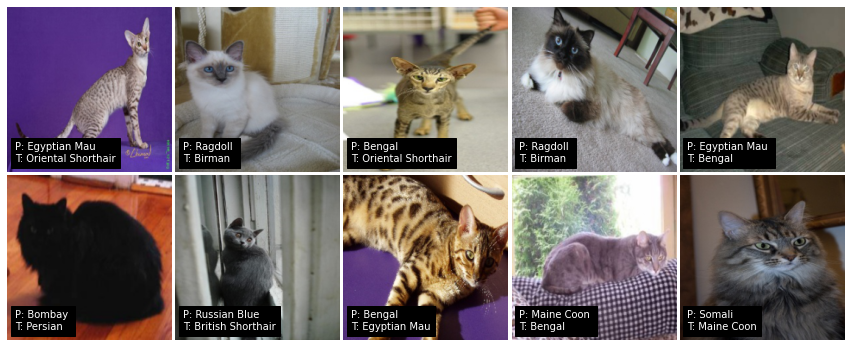

In [ ]:

test = [image[0].cpu() for image in misclassified_image]

fig = plt.figure(1, figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

for i,j in enumerate(random.sample(range(0, 50), 10)):
    image = test[j]
    label = misclassified_label[j]
    true = misclassified_true[j]
    ax = grid[i]
    ax.imshow(image.permute(1,2,0))
    ax.text(10, 210, f"P: {label} \nT: {true}", color='w', backgroundcolor='k')
    ax.axis(False)

plt.show()


<b>Confusion Matrix</b>

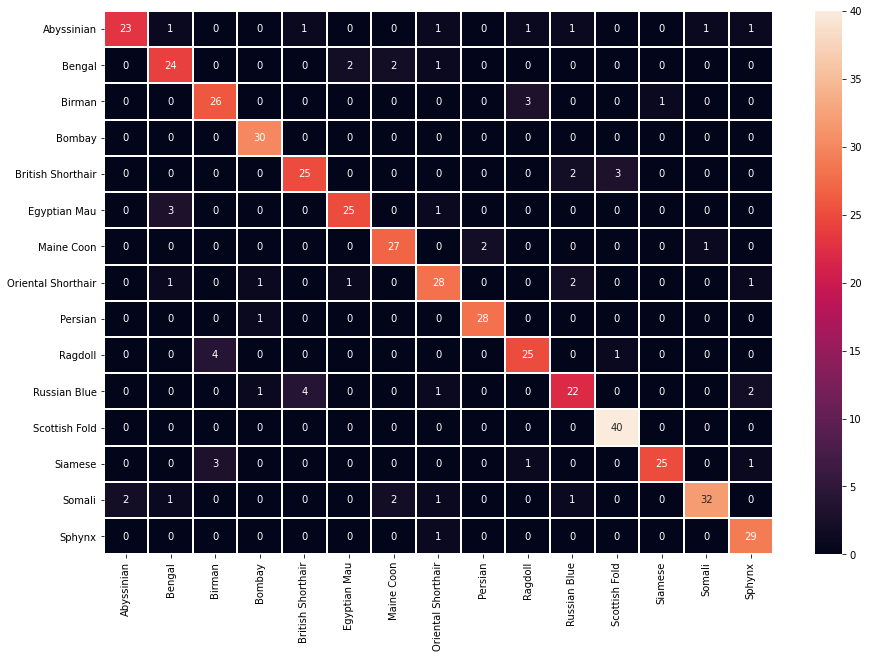

In [ ]:

y_true = class_mapper(y)
y_predictions = class_mapper(y_pred)
classes = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Oriental Shorthair', 
           'Persian', 'Ragdoll', 'Russian Blue', 'Scottish Fold', 'Siamese', 'Somali', 'Sphynx']
cf_matrix = confusion_matrix(y_true, y_predictions)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(cf_matrix, linewidths=1, xticklabels=classes,yticklabels=classes, annot=True, ax=ax, fmt='g')
